# SPGR

In [1]:
import version_control

Last run on cashlab03-deb at 2015-03-16 11:15:06.086163

Phypno Version: 71b052c80b564a062fb3738fdf00a5c692c759be

Babel==1.3, Cython==0.22, Jinja2==2.7.3, Markdown==2.6.1, MarkupSafe==0.23, Pillow==2.7.0, PyOpenGL==3.1.0, Pygments==2.0.2, Sphinx==1.3, alabaster==0.7.2, beautifulsoup4==4.3.2, certifi==14.05.14, coverage==3.7.1, decorator==3.4.0, docutils==0.12, easydev==0.8.3, ipython==3.0.0, jsonschema==2.4.0, matplotlib==1.4.3, memory-profiler==0.32, mistune==0.5.1, networkx==1.9.1, nibabel==2.0.0, nitime==0.5, nose==1.3.4, numpy==1.9.2, numpydoc==0.5, ordereddict==1.1, pandas==0.15.2, pandocfilters==1.2.3, pep8==1.6.2, pockets==0.2.3, psutil==2.2.1, pycurl==7.19.5.1, pyflakes==0.8.1, pyparsing==2.0.3, pyqtgraph==0.9.10, python-dateutil==2.4.1, python-igraph==0.7.1-4, pytz==2014.10, pyzmq==14.5.0, rope-py3k==0.9.4-1, rpy2==2.5.6, scikit-learn==0.15.2, scipy==0.15.1, six==1.9.0, snowballstemmer==1.2.0, sphinx-rtd-theme==0.1.7, sphinxcontrib-napoleon==0.3.1, spyder==2.3.3, tornado==4.1

In [2]:
from spgr import lg
from logging import INFO
lg.setLevel(INFO)

## Plot Coverage

In [3]:
from os import listdir, makedirs
from os.path import join

In [4]:
from numpy import NaN, atleast_2d, sum, histogram, log, nanmin, nanmax, median, nanmean, where, isnan, nansum, empty, ones

In [5]:
from phypno import Data
from phypno.attr import Freesurfer
from phypno.source import Linear, Morph
from phypno.viz.plot_3d import Viz3

In [6]:
from spgr.read_data import DATA_DIR, REC_DIR, FS_PATH, get_chan_used_in_analysis

In [11]:
all_subj = sorted(listdir(DATA_DIR))

hemi_subj = {'EM09': 'rh', 
             'MG17': 'rh',
             'MG33': 'lh',
             'MG37': 'lh',
             'MG61': 'lh',
             'MG63': 'rh',
             }

options = {'reref': 'avg',
           'resample_freq': 256,
           'hp_filter': 0.5,
           'lp_filter': 50,
           }

chan_type = ('grid', 'strip')

We projected the activity of each electrode to the cortex using a Gaussian window of standard deviation of 10mm.
Electrodes farther than 20 mm did not have any influence.

In [12]:
STD = 10
THRESHOLD = 20

Activity was morphed onto the average brain that ships with FreeSurfer.

For the six patients, 3 had coverage on the right and 3 had coverage on the left hemisphere.
The majority of the coverage was over the low frontal / frontal temporal regions (Table +[spgr_region_names]).

In [13]:
all_elec = []

for subj in all_subj:

    chan = get_chan_used_in_analysis(subj, 'sleep', chan_type, **options)[1]
    if hemi_subj[subj] == 'lh':
        for one_chan in chan.chan:
            one_chan.xyz *= (-1, 1, 1)

    data = Data(ones(chan.n_chan), chan=chan.return_label())

    fs = Freesurfer(join(REC_DIR, subj, FS_PATH))
    surf = fs.read_surf('rh')
    l = Linear(surf, chan, std=STD, threshold=THRESHOLD)
    m = Morph(surf)
    
    all_elec.append(m(l(data)))

INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:EM09 analysis chan 77, with location 77
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG17 analysis chan 104, with location 104
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG33 analysis chan 64, with location 64
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG37 analysis chan 78, with location 78
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG61 analysis chan 103, with location 103
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG63 analysis chan 99, with location 99


In [14]:
from copy import deepcopy
from numpy import nansum, NaN, asarray

avg_elec = deepcopy(all_elec[0])
avg_elec.data[0] = nansum(asarray([x.data[0] for x in all_elec]), axis=0)

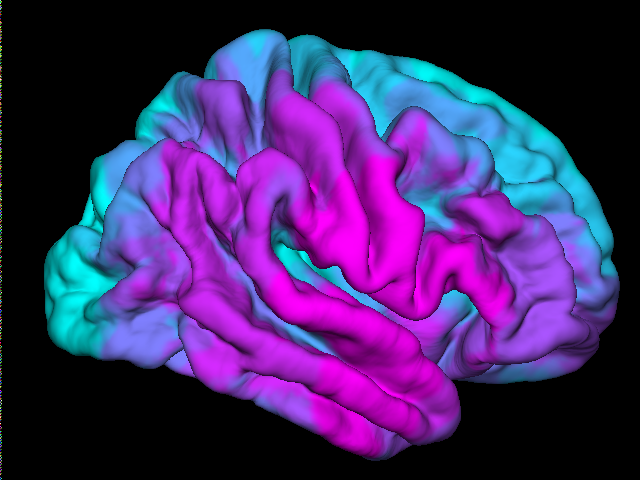

In [19]:
fs_avg = Freesurfer('/home/gio/recordings/EM09/mri/proc/fsaverage')
surf_avg = fs_avg.read_surf('rh', surf_type='pial')
v = Viz3()
v.add_surf(surf_avg, values=avg_elec(trial=0)[163842:], limits_c=(0, 6), colormap='cool')
v

In [22]:
from pathlib import Path

p_group = Path('/home/gio/projects/spgr/group')
p_fsaverage = p_group.joinpath('fsaverage')
p_fsaverage.mkdir()

In [26]:
subj_fs = '/home/gio/recordings/{}/mri/proc/freesurfer'

In [27]:
for subj in hemi_subj:
    one_subj = p_fsaverage.joinpath(subj)
    one_subj.symlink_to(subj_fs.format(subj))

In [25]:
print('export SUBJECTS_DIR=' + str(p_fsaverage))

export SUBJECTS_DIR=/home/gio/projects/spgr/group/fsaverage


'MG61 MG33 MG17 MG37 MG63 EM09'

In [32]:
print('make_average_subject --sdir ' + str(p_fsaverage) + ' --subjects ' + ' '.join(list(hemi_subj)) + ' --out average6 --no-vol')

make_average_subject --sdir /home/gio/projects/spgr/group/fsaverage --subjects MG61 MG33 MG17 MG37 MG63 EM09 --out average6 --no-vol


In [34]:
from phypno.attr import Surf
surf = Surf('/home/gio/projects/spgr/group/fsaverage/average6/surf/rh.pial')

v = Viz3()
v.add_surf(surf)